## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2022-01-10 15:02:20--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2022-01-10 15:02:21 (5.74 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.
lines = text
text = "".join([line.lower() for line in text])

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [4]:
text

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  feed'st thy light's flame with self-substantial fuel,\n  making a famine where abundance lies,\n  thy self thy foe, to thy sweet self too cruel:\n  thou that art now the world's fresh ornament,\n  and only herald to the gaudy spring,\n  within thine own bud buriest thy content,\n  and tender churl mak'st waste in niggarding:\n    pity the world, or else this glutton be,\n    to eat the world's due, by the grave and thee.\n\n  ii\n\n  when forty winters shall besiege thy brow,\n  and dig deep trenches in thy beauty's field,\n  thy youth's proud livery so gazed on now,\n  will be a tatter'd weed of small worth held:\n  then being asked, where all thy beauty lies,\n  where all the treasure of thy lusty days;\n  to say, within thine own deep sunken eyes,\n  were

### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-12-16 18:19:00--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2021-12-16 18:19:01 (8.22 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text)
text = text.lower()


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))
len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
# Your great code here
token_to_id = dict(zip(tokens, range(len(tokens))))

# dict <char>:<index>
# Your great code here
id_to_token = dict(zip(token_to_id.values(), token_to_id.keys()))

token_to_id, id_to_token

({'\n': 0,
  ' ': 1,
  '!': 2,
  "'": 3,
  '(': 4,
  ')': 5,
  ',': 6,
  '-': 7,
  '.': 8,
  ':': 9,
  ';': 10,
  '?': 11,
  'a': 12,
  'b': 13,
  'c': 14,
  'd': 15,
  'e': 16,
  'f': 17,
  'g': 18,
  'h': 19,
  'i': 20,
  'j': 21,
  'k': 22,
  'l': 23,
  'm': 24,
  'n': 25,
  'o': 26,
  'p': 27,
  'q': 28,
  'r': 29,
  's': 30,
  't': 31,
  'u': 32,
  'v': 33,
  'w': 34,
  'x': 35,
  'y': 36,
  'z': 37},
 {0: '\n',
  1: ' ',
  2: '!',
  3: "'",
  4: '(',
  5: ')',
  6: ',',
  7: '-',
  8: '.',
  9: ':',
  10: ';',
  11: '?',
  12: 'a',
  13: 'b',
  14: 'c',
  15: 'd',
  16: 'e',
  17: 'f',
  18: 'g',
  19: 'h',
  20: 'i',
  21: 'j',
  22: 'k',
  23: 'l',
  24: 'm',
  25: 'n',
  26: 'o',
  27: 'p',
  28: 'q',
  29: 'r',
  30: 's',
  31: 't',
  32: 'u',
  33: 'v',
  34: 'w',
  35: 'x',
  36: 'y',
  37: 'z'})

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [7]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE
        
        h_next = torch.tanh(h_next) # YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) # YOUR CODE
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [8]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [9]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))
        
    return torch.stack(logprobs, dim=1)

In [10]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c.lower()] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [11]:
batch_ix = to_matrix(text[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (len(tokens),)

In [12]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [29]:
MAX_LENGTH = 100

for i in range(10000):
    opt.zero_grad()
    
    batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1] # YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:] # YOUR CODE HERE
    
#     print(predictions_logp.shape, actual_next_tokens.shape)
    loss = criterion(
        predictions_logp.contiguous().view(-1, len(tokens)),
        actual_next_tokens.contiguous().view(-1)
    ) 
    # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    
    # YOUR CODE HERE
    
    history.append(loss.data.numpy())

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

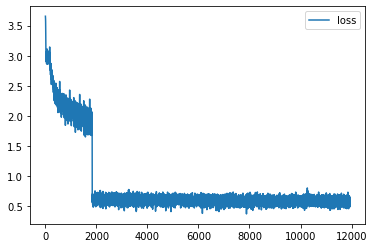

In [30]:
# Your plot code here

plt.plot(history,label='loss')
plt.legend()
plt.show()

In [15]:
def generate_sample(char_rnn, seed_phrase='in a while', max_length=500, temperature=0.5):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        #print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        #print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [20]:
# An example of generated text.
repr(generate_sample(char_rnn, seed_phrase='hello darknes my old friend'))

'"hello darknes my old friend be be thee with thee the would the love\'s of the see can dear beauty spold such pries shall not his love, but i fair wast strong,\\n                                                                                                                                                                                                                                                                                                                                                      "'

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [21]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm_size = 64
        self.embedding_dim = 64
        self.num_layers = 3

        n_vocab = len(tokens)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
    ):
        self.tokens = [char for char in text]
        self.uniq_tokens = tokens

        self.index_to_token = id_to_token
        self.token_to_index = token_to_id

        self.tokens_indexes = [self.token_to_index[w] for w in self.tokens]

    def __len__(self):
        return len(self.tokens_indexes) - SEQUENCE_LENGTH

    def __getitem__(self, index):
        return (
            torch.tensor(self.tokens_indexes[index:index+SEQUENCE_LENGTH]),
            torch.tensor(self.tokens_indexes[index+1:index+SEQUENCE_LENGTH+1]),
        )


def train(dataset, model):
    model.train()

    dataloader = DataLoader(dataset, batch_size=256)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(20):
        state_h, state_c = model.init_state(SEQUENCE_LENGTH)

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            history.append(loss.data.numpy())
            if batch % 10 == 0:
                clear_output(True)
                plt.plot(history,label='loss')
                plt.legend()
                plt.show()
          # print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })


def predict(dataset, model, text, temperature=1, next_chars=500):
    model.eval()

    words = [char for char in text]
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_chars):
        x = torch.tensor([[dataset.token_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits / temperature, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_token[word_index])

    return "".join(words)

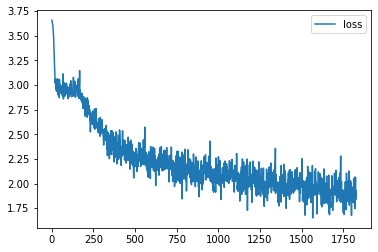

KeyboardInterrupt: ignored

In [22]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader

SEQUENCE_LENGTH = 40
myLSTM = LSTM()
dataset = Dataset()
history = []
train(dataset, myLSTM)

Plot the loss function of the number of epochs. Does the final loss become better?

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [23]:
for temp in [0.1, 0.2, 0.5, 1, 2]:
    print(f'T == {temp}')
    print(predict(dataset, myLSTM, 'one day', temp))
    print()

T == 0.1
one day the the the the thee thee thee,
  the the the the the the the the the the the the the the the thee,
  and the the the the the the the the the the the the the thee the thee,
  the the the the the the the the the the the the the the the the thee,
  the the the the the and the the the the the the the the thee thee,
  the the the the the the the the the the the the the the the thee thee,
  and the the the the the the the the the the the the the the thee thee thee thee.
  the the the the the the the

T == 0.2
one day me the the thee the thee thee.
  the the the me me the me the the she the the the rean,
  the and the the the the the the the the the the the the the love,
  and the the the the the the the the the the thee the sord,
  the the the the the the the thou the sorl the and she the thee,
  the the the the the the the the the the the the the me thee the thee,
  and the the love the the the the shere the the the the me thee,
    the the the the thou the the sort the th

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [24]:
# Saving and loading code here
torch.save(myLSTM, 'model')
model = torch.load('model')

print(predict(dataset, model, 'do i wanna', 0.5))

do i wannal-shire;
  the at thou but she all and thee the lolg the forgure;
  the in the where end the elint hi the in in lace,
    thou hen the that the but of love besend me mere pourd,
  the or do wone the the hort thereegh thee me purt,
  and she thing the lolse soeds me the loth dewess theu,
  whore where and song so thee best there me i mise,
  and for for the the the the prath the so dearty dost,
  the ian me anst and the in leed sore shey,
  the seur the me nand yar loth thee thee thee,
  whore th


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)